# Tutorial: ML Tools and Techniques

This tutorial explores different tools and techniques for writting your own neural networks. We will cover the following topics:

1. ML overview
    * Types of machine learning: supervised vs unsupervised
    * Types of ML problems: regression vs classification 

2. Key concepts
    * Tensor as data representation
    * Data processing: train-test-split, dataset and dataloader.
    * DNN Layers: input, hidden, activation
    * Loss functions and back propagation.
    * Training and validation loop
    * Hyperparameters: layers, nodes, batch size, epochs, learning rate, ...
    * Performance: loss distribution, ROC curve, ...

3. Tools
    * Pytorch, Pytroch lightning
    * TensorFlow, Keras
    * scikit-learn

4. Example: supervised classification using pytorch

## ML Overview

### Types of machine learning

1. Supervised learning
2. Unsupervised leanring

### Types of problems:

1. Regression
2. Classification

Let's work though some examples to understand loss functions and gradien decent for these two tasks.

## Key concepts

### Tensor as data representation

**Quote**: A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

In [1]:
import torch
import numpy as np

In [2]:
# Define total number of samples

N1 = 5

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, N1).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn(N1)

In [3]:
arr

array([-2.0408638 , -0.7178891 ,  0.750239  , -0.33758235, -0.8621032 ],
      dtype=float32)

In [4]:
t1

tensor([-2.0409, -0.7179,  0.7502, -0.3376, -0.8621])

In [5]:
t2

tensor([ 0.4425,  2.2462, -1.5938,  1.2597, -0.0190])

In [6]:
t3 = torch.tensor(arr.astype(np.float32))
t3

tensor([-2.0409, -0.7179,  0.7502, -0.3376, -0.8621])

In [7]:
# Repeat the above steps for a 2D gaussian and plot the samples

# Define total number of samples

N2 = 500

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, (N2, 2)).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn((N2, 2))

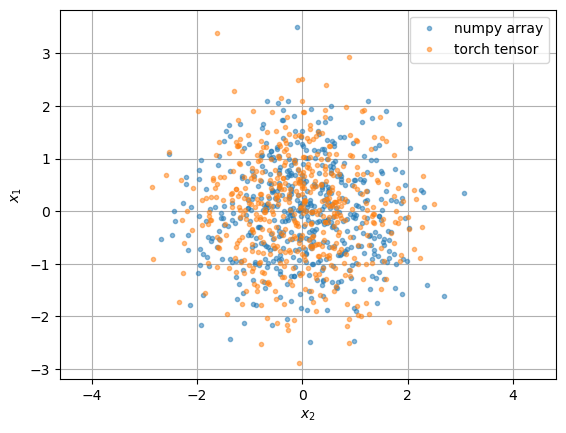

In [8]:
import matplotlib.pyplot as plt
plt.plot(arr[:, 0], arr[:, 1], '.', alpha=0.5, label="numpy array")
plt.plot(t2[:, 0], t2[:, 1], '.', alpha=0.5, label="torch tensor")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

In practice, the dataset we use is stored as numpy arrays. We convert the dateset to tensors load them on the GPU.

In [9]:
def np_to_torch(arr):

    return torch.tensor(arr.astype(np.float32))

### Data processing: train-test-split, dataset and dataloader.

Let's first create a dataset with gaussian signal and background events.

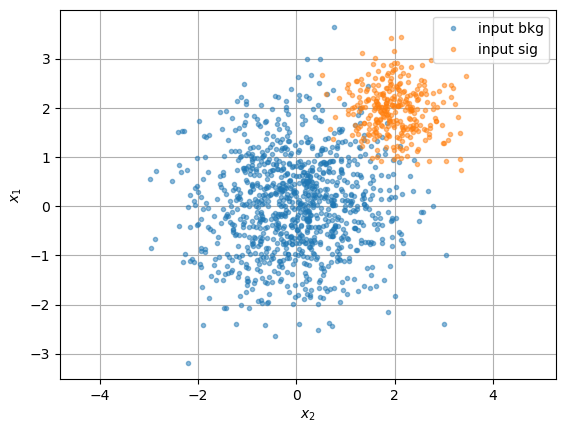

In [10]:
# First, create a dataset of gaussians using what we did above.

# Create an array called input_x which is the features of the traning set
# input_x consists of tow types of gaussians: input_bkg and input_sig

# input_bkg is 500 samples from a gaussian of N(0,1)
N_bkg = 1000
input_bkg = np.random.normal(0, 1, (N_bkg, 2)).astype(dtype=np.float32)

# input_sig is 500 samples from a gaussian of N(2,0.5)
N_sig = 300
input_sig = np.random.normal(2, 0.5, (N_sig, 2)).astype(dtype=np.float32)

# Plot input_x1 and input_x2
plt.plot(input_bkg[:, 0], input_bkg[:, 1], '.', alpha=0.5, label="input bkg")
plt.plot(input_sig[:, 0], input_sig[:, 1], '.', alpha=0.5, label="input sig")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

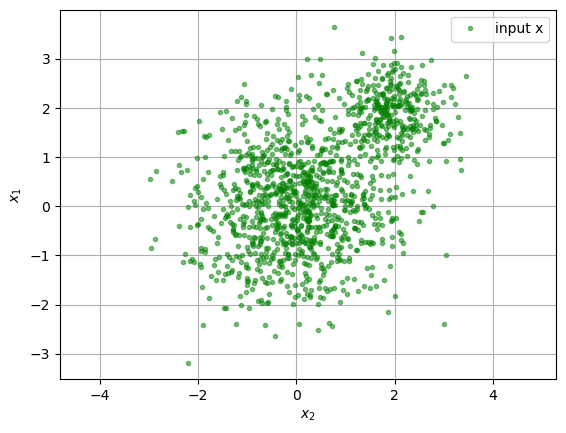

In [11]:
# create input_x which is a mixture of input_x1 and input_x2

input_x = np.concatenate([input_bkg, input_sig], axis=0)

# Plot input_x

plt.plot(input_x[:, 0], input_x[:, 1], '.', c="green", alpha=0.5, label="input x")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

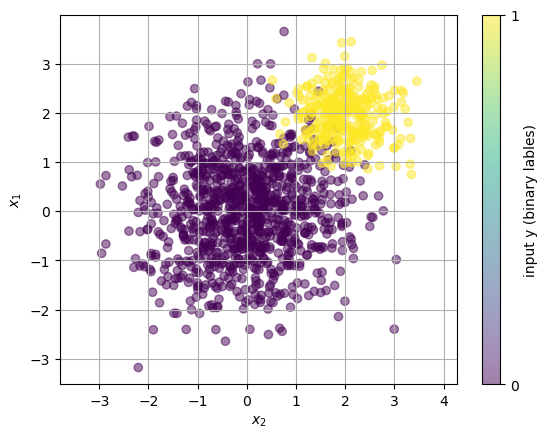

In [12]:
# create input_y which is the labels where input_x1 is labeled 0, and input_x2 is labeled 1

label_bkg = np.zeros(input_bkg.shape[0])  # Assign label 0 to input_x1
label_sig = np.ones(input_sig.shape[0])  # Assign label 1 to input_x2

input_y = np.concatenate([label_bkg, label_sig], axis=0).reshape(-1, 1)

# Plot input_y on the z-axis

sc = plt.scatter(input_x[:, 0], input_x[:, 1], c=input_y.flatten(), cmap='viridis', alpha=0.5)
plt.axis('equal')
plt.grid()
cbar = plt.colorbar(sc, ticks=[0, 1]) # Set the colorbar ticks to only show 0 and 1
cbar.set_label('input y (binary lables)')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.show()

The standard way to process data is to do the following:

1. Split the input dataset into training and validation sets.
2. Create TensorDataset for training and validation.
3. Create DataLoader for training and validation.

In [13]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [14]:
def process_data(input_x, input_y, batch_size):

    x_train, x_val, y_train, y_val = train_test_split(input_x, input_y, test_size=0.33, random_state=42)

    x_train = np_to_torch(x_train)
    y_train = np_to_torch(y_train)

    x_val = np_to_torch(x_val)
    y_val = np_to_torch(y_val)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

### DNN Layers: input, hidden, activation

**Input layer**: the first layer of a neural network.

**Hidden layers**: intermediate layers between the input and output layer and process the data by applying complex non-linear transformations. 

**Activation function**: after each hidden layer, we need to apply an activation function that defines how the weighted sum of the input is transformed into an output from a node or nodes in this layer of the network. A common activation function is `ReLU`, the Rectified Linear Unit function that returns 0 if it receives any negative input, and returns the same values for any positive inpout.

**Outoput layer**: The layer that generates the prediction of the network. In the case of a binary classifier, only 1 node is needed for the output layer. In the case of multiclass classification, multiple outputs, one for each class, is needed. The activation function used for the output layer of a binary classifer is the Sigmoid function.

In [15]:
import torch.nn as nn

In [16]:
class Model(nn.Module):
    def __init__(self, layers, n_inputs, device="cpu"):

        # The constructor of a simple DNN model
        # 
        # layers: a list of number of nodes in each layer. 
        #         For example layers=[56, 56, 56] represents 3 layers with 56 nodes in each layer.
        #
        # n_inputs: the number of input features.
        #
        # device: cpu or gpu device.
        
        super().__init__()

        # Initialize the layes of the network
        
        layer_list = []
        
        # First, define input layer
        nodes = layers[0]
        layer_list.append(nn.Linear(n_inputs, nodes))
        layer_list.append(nn.ReLU())
        
        n_inputs = nodes
        
        # Next, add the hidden layers
        for nodes in layers[1:]:
            layer_list.append(nn.Linear(n_inputs, nodes))
            layer_list.append(nn.ReLU())
            n_inputs = nodes
            
        # Then, add the output layer
        layer_list.append(nn.Linear(n_inputs, 1))
        layer_list.append(nn.Sigmoid())
        
        # Lastly, stack the layers with the nn.Sequential() function
        self.model_stack = nn.Sequential(*layer_list)

        # Specify the device
        self.device = device

    def forward(self, x):
        return self.model_stack(x)

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            x = torch.tensor(x, device=self.device)
            prediction = self.forward(x).detach().cpu().numpy()
        return prediction

### Loss function, forward-propagation, back-propagation, gradient descent.

**Loss function**: a mathematical function that quantifies the difference (loss) between predicted values (output) and target values (truth/labels).

**Forward propagation**: the process where the network takes the input data and calculates an output in a forward direction.

**Gradient descent**: the learning algorithm for multi-layer neural networks using the gradients of the loss function with respect to the model's parameters.

**Back-propagation**: the method for computing the gradient.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from tqdm import tqdm
import yaml
import os

In [18]:
# We use binary cross entropy loss for a binary classfier.

loss_func = F.binary_cross_entropy

### Training and validation loop

**Epochs**: the number of epochs is the number of complete passes through the training dataset.

**Batches**: the traning dataset is devided in to batches. The batch size controls the number of training samples to work through before the model’s internal parameters are updated.

The total dateset is devided in to training set, validation set, and test set.

**Training set**: the samples used to train the model. Gradient decent is performed on this dataset.

**Validation set**: the samples used to provide an unbiased evaluation of a model fit on the training dataset as the model parameters are being updated.

**Test set**: the samples used to evaluate the trained model.

In [19]:
# First, initialize a model

layers=[64,64,64]
n_inputs = 2
device = "cuda"

model = Model(layers=layers, n_inputs=n_inputs).to(device)

# Define loss funtion and optimizer
loss_func = F.binary_cross_entropy       

# Creat an output directory

outdir="./"
os.makedirs(outdir, exist_ok=True)

In [20]:
# Define traning paramaters
n_epochs=100
batch_size=256

learning_rate=1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

In [21]:
# Initialize training

update_epochs = 1

seed=1
torch.manual_seed(seed)
np.random.seed(seed)

epochs, epochs_val = [], []
losses, losses_val = [], []

train_data, val_data = process_data(input_x, input_y, batch_size=batch_size)

100%|==========| 100/100 [00:02<00:00, 47.65it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

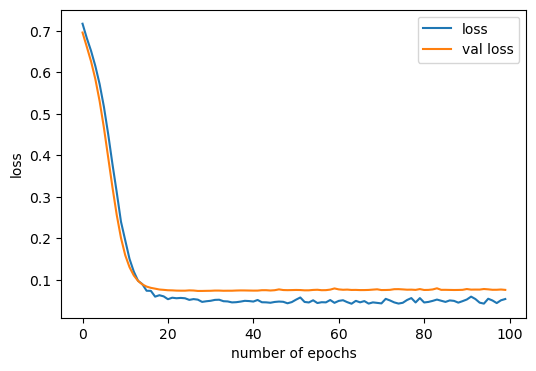

In [22]:
# Build a training loop

for epoch in tqdm(range(n_epochs), ascii=' >='):

    # Training

    losses_batch_per_e = []

    # set the mode to train
    model.train()

    for batch_ndx, data in enumerate(train_data):

        batch_inputs, batch_labels = data
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        
        # (Re)set gradients of all model parameters to zero.
        optimizer.zero_grad()
        
        # Calculate the predicted outputs of this batch
        batch_outputs = model(batch_inputs)
        
        # Calculate the loss
        loss = loss_func(batch_outputs, batch_labels)
        
        # Save the loss
        losses_batch_per_e.append(loss.detach().cpu().numpy())
        mean_loss = np.mean(losses_batch_per_e)
        
        # Perform backpropagation.
        loss.backward()
        
        # Update the model parameters based on the gradients calculated during backpropagation.
        optimizer.step()

    epochs.append(epoch)
    losses.append(mean_loss)


    # Validation

    # No backpropagation, make it faster.
    with torch.no_grad():

        # set the mode to eval
        model.eval()
        val_losses_batch_per_e = []

        for batch_ndx, data in enumerate(val_data):
            
            batch_inputs, batch_labels = data
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            batch_outputs = model(batch_inputs)
            val_loss = loss_func(batch_outputs, batch_labels)
            val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

        mean_val_loss = np.mean(val_losses_batch_per_e)
        losses_val.append(mean_val_loss)

        # print(f"Epoch: {epoch} - loss: {mean_loss} - val loss: {mean_val_loss}")


plt.figure(figsize=(6,4))
plt.plot(epochs, losses, label="loss")
plt.plot(epochs, losses_val, label="val loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show

**Note**

What's the difference between `zero_grad()` and `no_grad()`?


`zero_grad()` sets gradients of all model parameters to zero. This is the first setp of gradient decent.

`no_grad()` is a context-manager that disabled gradient calculation. Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.


### Prediction: evaluate the trained model

In [23]:
def evaluation(model, X_test,y_test=None):

    model.eval()

    with torch.no_grad():
        x_test = np_to_torch(X_test).to(device)
        outputs = model(x_test).detach().cpu().numpy()

        # calculate auc 
        if y_test is not None:
            auc = roc_auc_score(y_test, outputs)
            fpr, tpr, _ = roc_curve(y_test, outputs)

    if y_test is not None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(fpr, tpr, label=f"AUC: {auc:.3f}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"ROC curve")
        ax.plot([0,1],[0,1],color="gray",ls=":",label="Random")
        ax.legend()

        if auc < 0.5:
            auc = 1.0 - auc

        print(f"AUC: {auc}.")

    return outputs

AUC: 0.9972266666666666.


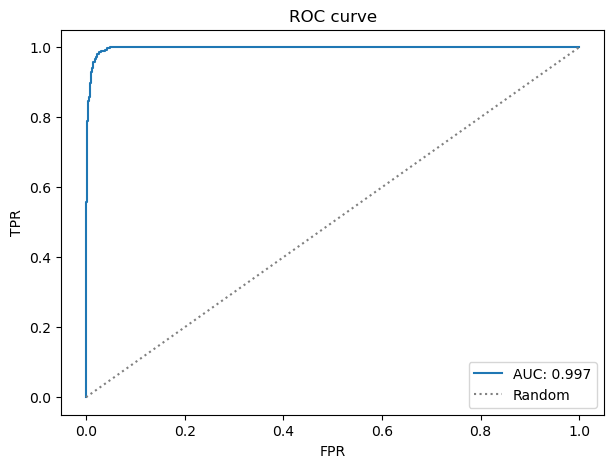

In [24]:
output = evaluation(model, input_x, input_y)